# Fungi Identification 2 - Inception V3


In order to avoid spending some hours reiterating the models built in keras, from scratch, I'm just creating a new notebook.


In [8]:
# imports cribbed from https://www.kaggle.com/code/erenicoz/birds-image-classification-with-inceptionv3 and cleaned up

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
import keras.preprocessing.image 
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D
from keras.applications import InceptionV3
from glob import glob
import matplotlib.image as mpimg

This warning (which also occurred in the first notebook) is a bit ominous, because it's _not correct_ - a quick command line "conda list numpy" shows that the installed version of NumPy is 1.20.3, which, by my calculation, is in fact between 1.16.5 and 1.23.0.  What's up here?  Regardless, nothing seemed to break in the first notebook, and it's entirely possible (indeed likely) that my NumPy version supports my SciPy version.  I proceed.

In [9]:
# as in Fungi Identification 1 notebook:

directory = "fungi images"
subdirs = ["\h1", "\h2", "\h3", "\h5", "\h6"]
labels = []
num_files = []
for subdir in subdirs:
    path = directory + subdir
    print(f"Folder {path} has {len(os.listdir(path))} files.")
    labels.append(subdir)
    num_files.append(len(os.listdir(path)))


Folder fungi images\h1 has 4404 files.
Folder fungi images\h2 has 2334 files.
Folder fungi images\h3 has 819 files.
Folder fungi images\h5 has 818 files.
Folder fungi images\h6 has 739 files.


In [10]:
def folder_images(source):
    images = []
    for filename in os.listdir(source):
        images.append(filename)
    return images

h1 = folder_images("fungi images\h1")
h2 = folder_images("fungi images\h2")
h3 = folder_images("fungi images\h3")
h5 = folder_images("fungi images\h5")
h6 = folder_images("fungi images\h6")

In [11]:
def rand_imgs_folder(source, num_imgs=4, max_cols=4, figsize=(12,8)):
    # load and randomly select images
    images = []
    for filename in os.listdir(source):
        images.append(filename)
    imgs = np.random.choice(images, num_imgs)
    
    # establish rows and columns    
    if num_imgs <= max_cols:
        cols = num_imgs
        rows = 1
    elif num_imgs > max_cols:
        cols = max_cols
        rows = int(np.ceil(num_imgs / max_cols))
    
    if num_imgs > 16:
        figsize=(20,14)
    elif num_imgs > 8:
        figsize=(16,11)
    
    # organize and draw the figure
    f = plt.figure(figsize=figsize)
    # WHY IS THIS SUDDENLY TELLING ME THAT FIGURE HAS NO AXIS METHOD???
    #f.axis('off')
    t = f"Images from {source}"
    plt.title(t)
    img_index = 0                                    # I hate this, but it works and I can't be bothered
    for img in imgs:
        img_index +=1
        f.add_subplot(rows, cols, img_index)
        image = mpimg.imread(source+"\\"+img)
        plt.imshow(image)
        plt.axis('off')
        plt.title(img)
    plt.show()

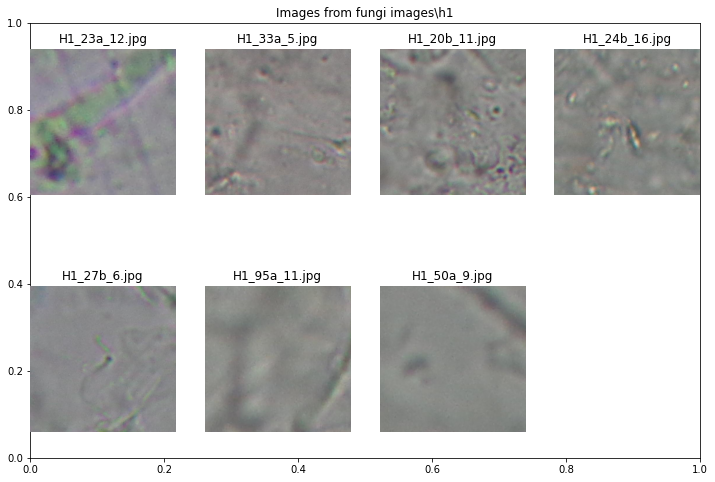

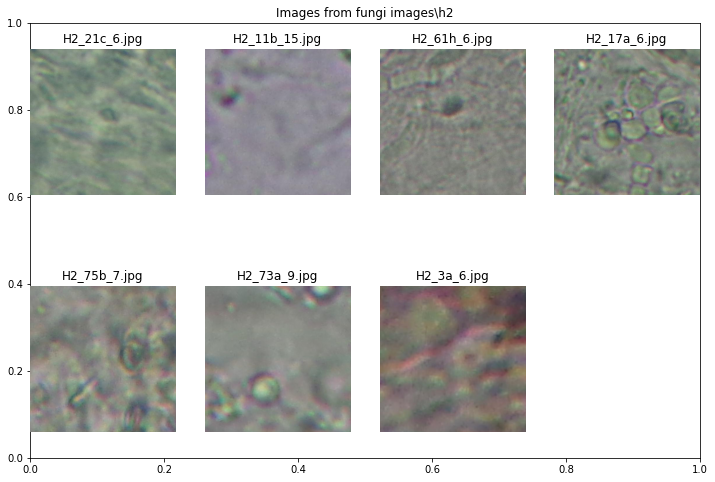

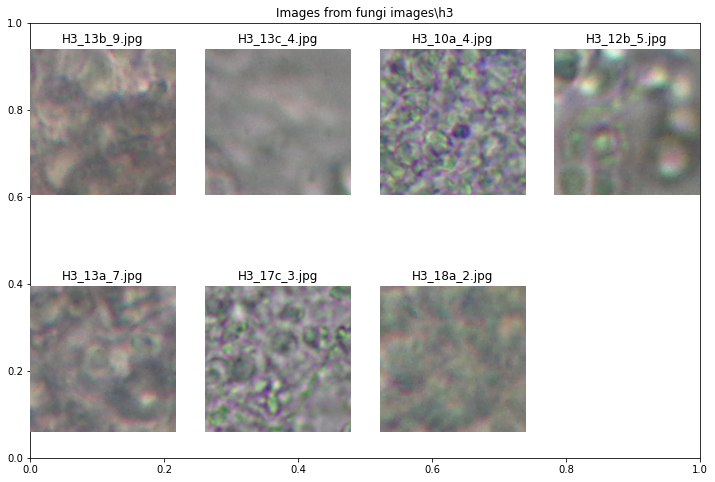

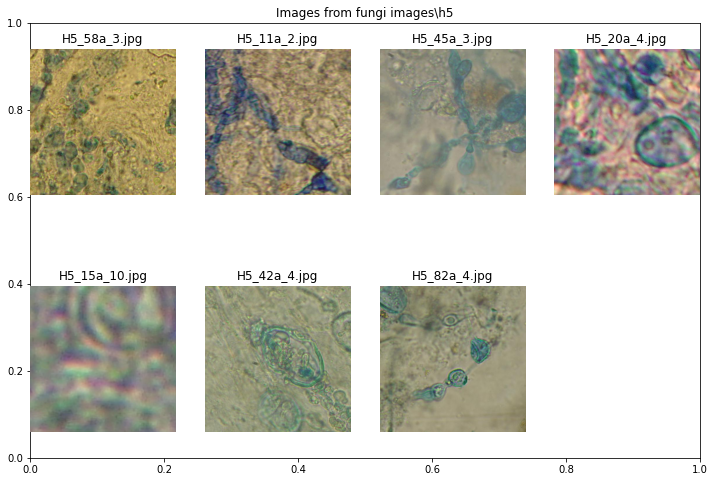

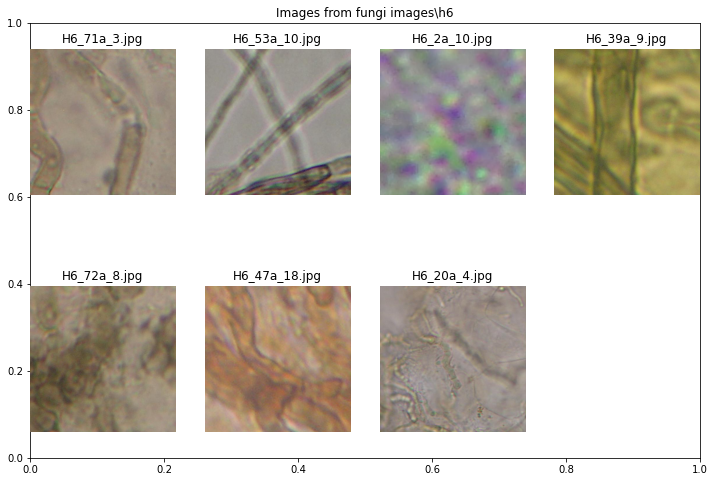

In [12]:
rand_imgs_folder("fungi images\h1", num_imgs=7)
rand_imgs_folder("fungi images\h2", num_imgs=7)
rand_imgs_folder("fungi images\h3", num_imgs=7)
rand_imgs_folder("fungi images\h5", num_imgs=7)
rand_imgs_folder("fungi images\h6", num_imgs=7)

So far, (almost) so good - the f.axis() failure is difficult to explain.  Let's proceed.

In [13]:
from PIL import Image

# this isn't great but using a dict seems to be the best easy way 

labels = {'h1': 0,
         'h2': 1,
         'h3': 2,
         'h5': 3,
         'h6': 4}

X=[]
Y=[]

for dir, label in labels.items():
    path = "fungi images\\"+dir
    img_files = os.listdir(path)
    for file in img_files:
        #X.append(mpimg.imread(path+"\\"+file))
        # With 500x500x3 image sizes, I was getting runtimes around 15 mins/epoch for batch sizes of 20.  
        # Need to rescale images and maybe grayscale them.
        X.append(Image.open(path+"\\"+file).resize((200, 200), Image.ANTIALIAS))
        Y.append(label)
        #print("file "+path+"\\"+file+" appended")

In [14]:
from sklearn.model_selection import train_test_split

X = np.array(X)
# meant to keep it lower case
y = np.array(Y)

# split these data... for a first run, let's just do a train-test split with no reserved validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13013)

In [15]:
IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))



In [62]:
CNNmodel_1 = Sequential()

CNNmodel_1.add(IV3)

# using weights from imagenet as is

for layer in CNNmodel_1.layers:
    layer.trainable = False
    
# flatten, add final dense layer, add softmax layer
    
CNNmodel_1.add(Flatten())    
CNNmodel_1.add(Dense(2048, activation='relu'))
CNNmodel_1.add(Dropout(0.2))
CNNmodel_1.add(Dense(5, activation='softmax'))

CNNmodel_1.summary()
    

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 2048)              67110912  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 88,923,941
Trainable params: 67,121,157
Non-trainable params: 21,802,784
_________________________________________________________________


In [66]:
CNNmodel_1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [67]:
tf.debugging.enable_traceback_filtering()

In [68]:
CNNmodel_1_fit = CNNmodel_1.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 309s 1s/step - loss: 123.0249 - accuracy: 0.4430 - val_loss: 1.5240 - val_accuracy: 0.4822
Epoch 2/10
228/228 [==============================] - 310s 1s/step - loss: 1.7671 - accuracy: 0.4962 - val_loss: 1.2838 - val_accuracy: 0.5080
Epoch 3/10
228/228 [==============================] - 313s 1s/step - loss: 1.2690 - accuracy: 0.5017 - val_loss: 1.1710 - val_accuracy: 0.4849
Epoch 4/10
228/228 [==============================] - 309s 1s/step - loss: 1.2142 - accuracy: 0.5097 - val_loss: 1.1611 - val_accuracy: 0.4942
Epoch 5/10
228/228 [==============================] - 311s 1s/step - loss: 1.2282 - accuracy: 0.5032 - val_loss: 1.1636 - val_accuracy: 0.4739
Epoch 6/10
228/228 [==============================] - 332s 1s/step - loss: 1.2163 - accuracy: 0.4995 - val_loss: 1.2473 - val_accuracy: 0.4739
Epoch 7/10
228/228 [==============================] - 370s 2s/step - loss: 1.2164 - accuracy: 0.4918 - val_loss: 1.1583 - val_accuracy: 0.48

_Note to self:_ I tinkered endlessly with the above model, getting time and again the ValueError: sizes (None,1) and (None,5) are incompatible.  Changing the model architecture did nothing to fix this (except that if I stripped down to a bare InceptionV3 model, the sizes in the ValueError changed) _but_ changing the loss function to '_sparse_ categorical crossentropy" _did work_.  This is mysterious to me; why the _loss function_ should have any effect on this is beyond me for now.

Another concern:  this model didn't appear to improve across epochs, from a cursory glance at the list of accuracies.  Why is this?  Am I misusing InceptionV3 somehow?  Do I need to make layer.trainable = True for the InceptionV3 layers?  Would some other convolutional layers help?



In [69]:
# CNN model 2:  only changing to layer.trainable = true for InceptionV3 layers

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_2 = Sequential()

CNNmodel_2.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_2.layers:
    layer.trainable = True
    
# flatten, add final dense layer, add softmax layer
    
CNNmodel_2.add(Flatten())    
CNNmodel_2.add(Dense(2048, activation='relu'))
CNNmodel_2.add(Dropout(0.2))
CNNmodel_2.add(Dense(5, activation='softmax'))

CNNmodel_2.summary()
    

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_11 (Dense)            (None, 2048)              67110912  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 88,923,941
Trainable params: 88,889,509
Non-trainable params: 34,432
_________________________________________________________________


In [73]:
CNNmodel_2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [74]:
CNNmodel_2_fit = CNNmodel_2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 954s 4s/step - loss: 1.7162 - accuracy: 0.5673 - val_loss: 1.0698 - val_accuracy: 0.6402
Epoch 2/10
228/228 [==============================] - 988s 4s/step - loss: 0.8850 - accuracy: 0.6512 - val_loss: 543.4808 - val_accuracy: 0.5014
Epoch 3/10
228/228 [==============================] - 1113s 5s/step - loss: 0.8781 - accuracy: 0.6616 - val_loss: 1.0476 - val_accuracy: 0.5524
Epoch 4/10
228/228 [==============================] - 1016s 4s/step - loss: 0.7675 - accuracy: 0.6992 - val_loss: 1.5028 - val_accuracy: 0.5469
Epoch 5/10
228/228 [==============================] - 1031s 5s/step - loss: 0.7241 - accuracy: 0.7213 - val_loss: 327.9086 - val_accuracy: 0.2183
Epoch 6/10
228/228 [==============================] - 935s 4s/step - loss: 0.7113 - accuracy: 0.7176 - val_loss: 1.0876 - val_accuracy: 0.5529
Epoch 7/10
228/228 [==============================] - 944s 4s/step - loss: 0.7258 - accuracy: 0.7166 - val_loss: 1.3011 - val_accuracy:

Interesting: changing the InceptionV3 layers to 'trainable' increased the number of trainable parameters by about a third (~20 million more) but more than doubled the fitting time.   Accuracy is substantially improved.  Let's try a (slightly) different model architecture.

In [75]:
# CNN model 3:  adding another Dense() layer, sticking with 'layer_trainable=True'

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_3 = Sequential()

CNNmodel_3.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_3.layers:
    layer.trainable = True
    
# flatten, add final dense layers, add softmax layer
    
CNNmodel_3.add(Flatten())    
CNNmodel_3.add(Dense(2048, activation='relu'))
CNNmodel_3.add(Dense(2048, activation='relu'))
CNNmodel_3.add(Dropout(0.2))
CNNmodel_3.add(Dense(5, activation='softmax'))

CNNmodel_3.summary()
    

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_13 (Dense)            (None, 2048)              67110912  
                                                                 
 dense_14 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 93,120,293
Trainable params: 93,085,861

In [76]:
CNNmodel_3.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [77]:
CNNmodel_3_fit = CNNmodel_3.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 972s 4s/step - loss: 1.7631 - accuracy: 0.5309 - val_loss: 1.0824 - val_accuracy: 0.5749
Epoch 2/10
228/228 [==============================] - 953s 4s/step - loss: 0.9407 - accuracy: 0.6221 - val_loss: 7.0524 - val_accuracy: 0.6138
Epoch 3/10
228/228 [==============================] - 996s 4s/step - loss: 0.8296 - accuracy: 0.6674 - val_loss: 0.8059 - val_accuracy: 0.6637
Epoch 4/10
228/228 [==============================] - 1059s 5s/step - loss: 0.7276 - accuracy: 0.7180 - val_loss: 0.8784 - val_accuracy: 0.6555
Epoch 5/10
228/228 [==============================] - 952s 4s/step - loss: 0.6797 - accuracy: 0.7349 - val_loss: 1.4212 - val_accuracy: 0.5140
Epoch 6/10
228/228 [==============================] - 949s 4s/step - loss: 0.7550 - accuracy: 0.7055 - val_loss: 1.1512 - val_accuracy: 0.4915
Epoch 7/10
228/228 [==============================] - 951s 4s/step - loss: 0.7221 - accuracy: 0.7165 - val_loss: 0.7012 - val_accuracy: 0.720

In [78]:
# CNN model 4:  accidentally the same???

# CNN model 3:  adding another Dense() layer, sticking with 'layer_trainable=True'

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_4 = Sequential()

CNNmodel_4.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_4.layers:
    layer.trainable = True
    
# flatten, add final dense layers, add softmax layer
    
CNNmodel_4.add(Flatten())    
CNNmodel_4.add(Dense(2048, activation='relu'))
CNNmodel_4.add(Dense(2048, activation='relu'))
CNNmodel_4.add(Dropout(0.2))
CNNmodel_4.add(Dense(5, activation='softmax'))

CNNmodel_4.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_16 (Dense)            (None, 2048)              67110912  
                                                                 
 dense_17 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 93,120,293
Trainable params: 93,085,861

In [79]:
CNNmodel_4.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [80]:
CNNmodel_4_fit = CNNmodel_4.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 967s 4s/step - loss: 1.8858 - accuracy: 0.5050 - val_loss: 5.1074 - val_accuracy: 0.4043
Epoch 2/10
228/228 [==============================] - 948s 4s/step - loss: 0.9923 - accuracy: 0.5983 - val_loss: 1.6658 - val_accuracy: 0.3066
Epoch 3/10
228/228 [==============================] - 951s 4s/step - loss: 0.9179 - accuracy: 0.6405 - val_loss: 5.5227 - val_accuracy: 0.1234
Epoch 4/10
228/228 [==============================] - 946s 4s/step - loss: 0.8783 - accuracy: 0.6431 - val_loss: 0.9447 - val_accuracy: 0.6259
Epoch 5/10
228/228 [==============================] - 957s 4s/step - loss: 0.8926 - accuracy: 0.6515 - val_loss: 1.3543 - val_accuracy: 0.4712
Epoch 6/10
228/228 [==============================] - 946s 4s/step - loss: 0.8170 - accuracy: 0.6741 - val_loss: 0.8689 - val_accuracy: 0.6341
Epoch 7/10
228/228 [==============================] - 947s 4s/step - loss: 0.7576 - accuracy: 0.6935 - val_loss: 1.9422 - val_accuracy: 0.1673

Inserting the extra dense layer _after_ dropout proved problematic.  Validation accuracy was all over the place.  Not the right path, apparently - although I should read up more.

In [81]:
# model 5 - what model 4 was intended to be

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_5 = Sequential()

CNNmodel_5.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_5.layers:
    layer.trainable = True
    
# flatten, add final dense layers, add softmax layer
    
CNNmodel_5.add(Flatten())    
CNNmodel_5.add(Dense(2048, activation='relu'))
CNNmodel_5.add(Dropout(0.2))
CNNmodel_5.add(Dense(2048, activation='relu'))
CNNmodel_5.add(Dense(5, activation='softmax'))

CNNmodel_5.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_19 (Dense)            (None, 2048)              67110912  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_21 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 93,120,293
Trainable params: 93,085,861

In [82]:
CNNmodel_5.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
CNNmodel_5_fit = CNNmodel_5.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
228/228 [==============================] - 1057s 5s/step - loss: 1.6960 - accuracy: 0.5298 - val_loss: 1.0848 - val_accuracy: 0.5145
Epoch 2/10
228/228 [==============================] - 950s 4s/step - loss: 0.9668 - accuracy: 0.6075 - val_loss: 1.0881 - val_accuracy: 0.5650
Epoch 3/10
228/228 [==============================] - 952s 4s/step - loss: 0.8584 - accuracy: 0.6634 - val_loss: 1.8453 - val_accuracy: 0.6270
Epoch 4/10
228/228 [==============================] - 954s 4s/step - loss: 0.8023 - accuracy: 0.6955 - val_loss: 1.3731 - val_accuracy: 0.3527
Epoch 5/10
228/228 [==============================] - 951s 4s/step - loss: 0.7458 - accuracy: 0.7080 - val_loss: 0.8588 - val_accuracy: 0.6467
Epoch 6/10
228/228 [==============================] - 955s 4s/step - loss: 0.7016 - accuracy: 0.7283 - val_loss: 1.9090 - val_accuracy: 0.2990
Epoch 7/10
228/228 [==============================] - 951s 4s/step - loss: 0.7862 - accuracy: 0.7032 - val_loss: 1.6814 - val_accuracy: 0.338

In [83]:
# model 6 - 

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_6 = Sequential()

CNNmodel_6.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_6.layers:
    layer.trainable = True
    
# flatten, add final dense layers, add softmax layer
    
CNNmodel_6.add(Flatten())    
CNNmodel_6.add(Dense(2048, activation='relu'))
CNNmodel_6.add(Dropout(0.2))
CNNmodel_6.add(Dense(2048, activation='relu'))
CNNmodel_6.add(Dropout(0.2))
CNNmodel_6.add(Dense(5, activation='softmax'))

CNNmodel_6.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_10 (Flatten)        (None, 32768)             0         
                                                                 
 dense_22 (Dense)            (None, 2048)              67110912  
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 5)               

In [84]:
CNNmodel_6.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
CNNmodel_6_fit = CNNmodel_6.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 973s 4s/step - loss: 1.8139 - accuracy: 0.5088 - val_loss: 1.4202 - val_accuracy: 0.3642
Epoch 2/10
228/228 [==============================] - 956s 4s/step - loss: 1.0583 - accuracy: 0.5684 - val_loss: 0.9509 - val_accuracy: 0.5935
Epoch 3/10
228/228 [==============================] - 958s 4s/step - loss: 0.9603 - accuracy: 0.6209 - val_loss: 3.0832 - val_accuracy: 0.6204
Epoch 4/10
228/228 [==============================] - 954s 4s/step - loss: 0.8805 - accuracy: 0.6497 - val_loss: 0.9757 - val_accuracy: 0.6007
Epoch 5/10
228/228 [==============================] - 950s 4s/step - loss: 0.8834 - accuracy: 0.6577 - val_loss: 0.9617 - val_accuracy: 0.6045
Epoch 6/10
228/228 [==============================] - 950s 4s/step - loss: 0.8301 - accuracy: 0.6701 - val_loss: 0.9024 - val_accuracy: 0.6352
Epoch 7/10
228/228 [==============================] - 949s 4s/step - loss: 0.9007 - accuracy: 0.6453 - val_loss: 1.0040 - val_accuracy: 0.5924

In [85]:
# model 7 - 

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_7 = Sequential()

CNNmodel_7.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_7.layers:
    layer.trainable = True
    
# flatten, add final dense layers, add softmax layer
    
CNNmodel_7.add(Flatten())    
CNNmodel_7.add(Dense(2048, activation='relu'))
# increasing first dropout
CNNmodel_7.add(Dropout(0.4))
CNNmodel_7.add(Dense(2048, activation='relu'))
CNNmodel_7.add(Dense(2048, activation='relu'))
CNNmodel_7.add(Dropout(0.2))
CNNmodel_7.add(Dense(5, activation='softmax'))

CNNmodel_7.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_11 (Flatten)        (None, 32768)             0         
                                                                 
 dense_25 (Dense)            (None, 2048)              67110912  
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_27 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_10 (Dropout)        (None, 2048)            

In [86]:
CNNmodel_7.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
CNNmodel_7_fit = CNNmodel_7.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 980s 4s/step - loss: 1.6683 - accuracy: 0.5250 - val_loss: 1.6630 - val_accuracy: 0.5266
Epoch 2/10
228/228 [==============================] - 967s 4s/step - loss: 1.0008 - accuracy: 0.6002 - val_loss: 1.0216 - val_accuracy: 0.6018
Epoch 3/10
228/228 [==============================] - 968s 4s/step - loss: 0.9381 - accuracy: 0.6268 - val_loss: 1.4757 - val_accuracy: 0.5217
Epoch 4/10
228/228 [==============================] - 966s 4s/step - loss: 0.8898 - accuracy: 0.6520 - val_loss: 1.2545 - val_accuracy: 0.4986
Epoch 5/10
228/228 [==============================] - 975s 4s/step - loss: 0.8024 - accuracy: 0.6865 - val_loss: 1.0425 - val_accuracy: 0.5721
Epoch 6/10
228/228 [==============================] - 966s 4s/step - loss: 0.8805 - accuracy: 0.6574 - val_loss: 1.1500 - val_accuracy: 0.6917
Epoch 7/10
228/228 [==============================] - 1390s 6s/step - loss: 0.7973 - accuracy: 0.6836 - val_loss: 0.8656 - val_accuracy: 0.652

In [87]:
# let's graph the results so far

def plot_epochs(model_fit, model_id=""):
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    epochs = list(range(1, (len(acc) + 1)))
    plt.plot(epochs, acc, label="accuracy")
    plt.plot(epochs, val_acc, label="validation accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.xticks(epochs)
    plt.title("accuracy for CNN model " + model_id)
    plt.legend()
    plt.show()

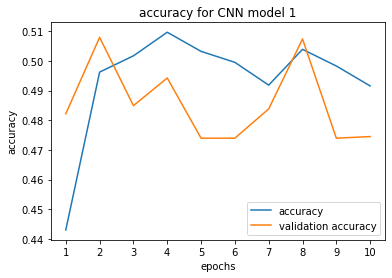

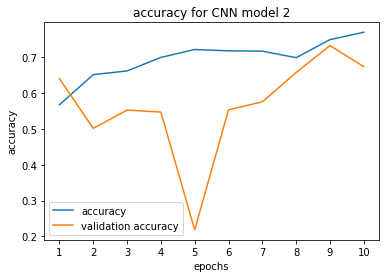

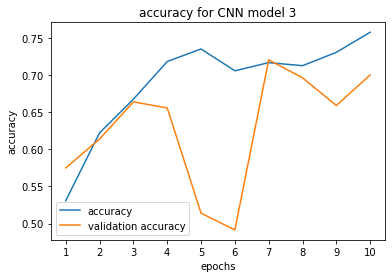

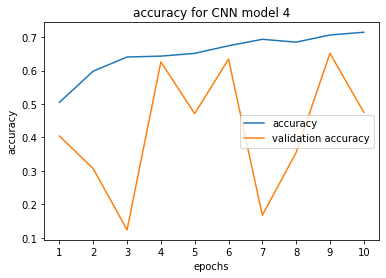

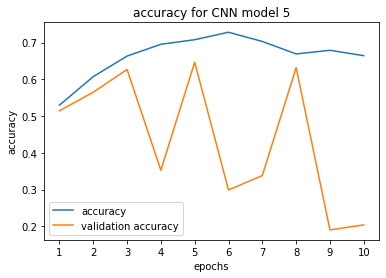

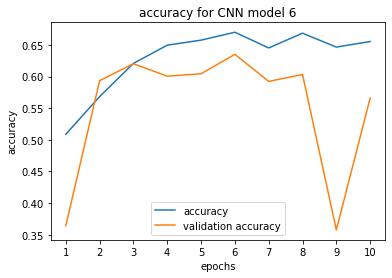

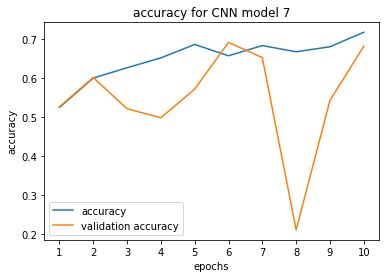

In [88]:
elist = list(range(1, 8))
for e in elist:
    stringname = "CNNmodel_" + str(e) + "_fit"
    plot_epochs(eval(stringname), str(e))

 Let's do some more.  All of these have Dense() layers of size 2048.  What if we add more, smaller layers?

In [89]:
# model 8 - reducing Dense size 

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_8 = Sequential()

CNNmodel_8.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_8.layers:
    layer.trainable = True
    
# flatten, add final dense layers, dropout, add softmax layer
    
CNNmodel_8.add(Flatten())    
CNNmodel_8.add(Dense(512, activation='relu'))
CNNmodel_8.add(Dropout(0.2))
CNNmodel_8.add(Dense(5, activation='softmax'))

CNNmodel_8.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_12 (Flatten)        (None, 32768)             0         
                                                                 
 dense_29 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 38,583,077
Trainable params: 38,548,645
Non-trainable params: 34,432
_________________________________________________________________


In [90]:
CNNmodel_8.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
CNNmodel_8_fit = CNNmodel_8.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 944s 4s/step - loss: 1.4676 - accuracy: 0.5452 - val_loss: 1.1313 - val_accuracy: 0.5826
Epoch 2/10
228/228 [==============================] - 852s 4s/step - loss: 0.9320 - accuracy: 0.6230 - val_loss: 1.6105 - val_accuracy: 0.0730
Epoch 3/10
228/228 [==============================] - 853s 4s/step - loss: 0.8477 - accuracy: 0.6582 - val_loss: 0.8695 - val_accuracy: 0.6434
Epoch 4/10
228/228 [==============================] - 853s 4s/step - loss: 0.7950 - accuracy: 0.6935 - val_loss: 1.6185 - val_accuracy: 0.6890
Epoch 5/10
228/228 [==============================] - 862s 4s/step - loss: 0.7068 - accuracy: 0.7302 - val_loss: 0.8430 - val_accuracy: 0.7016
Epoch 6/10
228/228 [==============================] - 852s 4s/step - loss: 0.6738 - accuracy: 0.7446 - val_loss: 0.9585 - val_accuracy: 0.6643
Epoch 7/10
228/228 [==============================] - 852s 4s/step - loss: 0.6358 - accuracy: 0.7535 - val_loss: 3.6634 - val_accuracy: 0.0373

In [91]:
# model 9 - reducing Dense size but more layers

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_9 = Sequential()

CNNmodel_9.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_9.layers:
    layer.trainable = True
    
# flatten, add final dense layers, dropout, add softmax layer
    
CNNmodel_9.add(Flatten())    
CNNmodel_9.add(Dense(512, activation='relu'))
CNNmodel_9.add(Dense(512, activation='relu'))
CNNmodel_9.add(Dropout(0.2))
CNNmodel_9.add(Dense(5, activation='softmax'))

CNNmodel_9.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_13 (Flatten)        (None, 32768)             0         
                                                                 
 dense_31 (Dense)            (None, 512)               16777728  
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 38,845,733
Trainable params: 38,811,301

In [92]:
CNNmodel_9.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
CNNmodel_9_fit = CNNmodel_9.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 894s 4s/step - loss: 1.4726 - accuracy: 0.5213 - val_loss: 2.5053 - val_accuracy: 0.5250
Epoch 2/10
228/228 [==============================] - 868s 4s/step - loss: 0.9459 - accuracy: 0.5954 - val_loss: 1.9435 - val_accuracy: 0.4986
Epoch 3/10
228/228 [==============================] - 860s 4s/step - loss: 0.9332 - accuracy: 0.6001 - val_loss: 5.8812 - val_accuracy: 0.0922
Epoch 4/10
228/228 [==============================] - 859s 4s/step - loss: 1.0668 - accuracy: 0.5667 - val_loss: 1.1706 - val_accuracy: 0.4844
Epoch 5/10
228/228 [==============================] - 859s 4s/step - loss: 1.0103 - accuracy: 0.5743 - val_loss: 1.1491 - val_accuracy: 0.4816
Epoch 6/10
228/228 [==============================] - 1039s 5s/step - loss: 0.9696 - accuracy: 0.6028 - val_loss: 1.1611 - val_accuracy: 0.5518
Epoch 7/10
228/228 [==============================] - 1472s 6s/step - loss: 0.9534 - accuracy: 0.6129 - val_loss: 2.0327 - val_accuracy: 0.24

In [93]:
# model 10 - reducing Dense size but more layers

IV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (200, 200, 3))

CNNmodel_10 = Sequential()

CNNmodel_10.add(IV3)

# making imagenet weights trainable

for layer in CNNmodel_10.layers:
    layer.trainable = True
    
# flatten, add final dense layers, dropout, add softmax layer
    
CNNmodel_10.add(Flatten())    
CNNmodel_10.add(Dense(512, activation='relu'))
CNNmodel_10.add(Dropout(0.2))
CNNmodel_10.add(Dense(512, activation='relu'))
CNNmodel_10.add(Dropout(0.2))
CNNmodel_10.add(Dense(5, activation='softmax'))

CNNmodel_10.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_14 (Flatten)        (None, 32768)             0         
                                                                 
 dense_34 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 5)               

In [94]:
CNNmodel_10.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
CNNmodel_10_fit = CNNmodel_10.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
228/228 [==============================] - 905s 4s/step - loss: 1.4258 - accuracy: 0.5250 - val_loss: 1.5486 - val_accuracy: 0.5052
Epoch 2/10
228/228 [==============================] - 870s 4s/step - loss: 0.9526 - accuracy: 0.6018 - val_loss: 1.3968 - val_accuracy: 0.4608
Epoch 3/10
228/228 [==============================] - 865s 4s/step - loss: 0.8473 - accuracy: 0.6553 - val_loss: 1.3211 - val_accuracy: 0.5321
Epoch 4/10
228/228 [==============================] - 863s 4s/step - loss: 0.8292 - accuracy: 0.6726 - val_loss: 18.3208 - val_accuracy: 0.4591
Epoch 5/10
228/228 [==============================] - 863s 4s/step - loss: 0.7431 - accuracy: 0.7090 - val_loss: 1.2348 - val_accuracy: 0.4794
Epoch 6/10
228/228 [==============================] - 862s 4s/step - loss: 1.0651 - accuracy: 0.5874 - val_loss: 1.5415 - val_accuracy: 0.3555
Epoch 7/10
228/228 [==============================] - 867s 4s/step - loss: 1.0399 - accuracy: 0.5717 - val_loss: 2.5960 - val_accuracy: 0.133

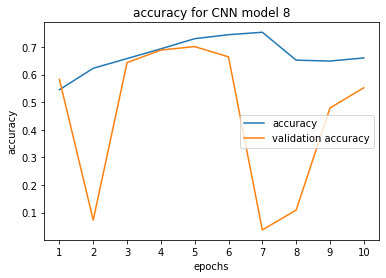

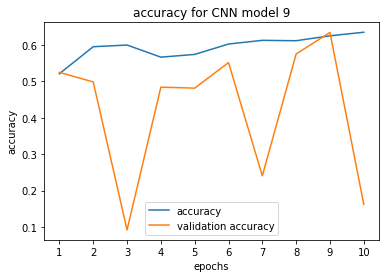

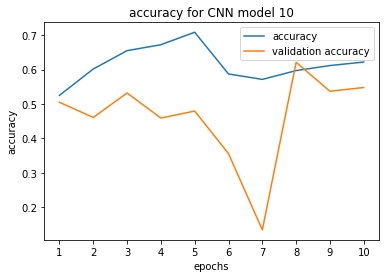

In [95]:
elist = list(range(8, 11))
for e in elist:
    stringname = "CNNmodel_" + str(e) + "_fit"
    plot_epochs(eval(stringname), str(e))